# ML Short term prediction of ROI for portfolio
ML models are use to provide short term predictions of ROI for a given portfolio. (given tickers)

## Libraries installation and importation


In [1]:
pip install tensorflow 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline
import datetime as dt 
import mplfinance as mpf
import yfinance as yf
import datetime as dt


import time

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order


## Functions

In [3]:
# Function that gets a dataframe by providing a ticker and starting date
def save_to_csv_from_yahoo(path, tickers, syear, smonth, sday, eyear, emonth, eday):
    start = dt.datetime(syear, smonth, sday)
    end = dt.datetime(eyear, emonth, eday)
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)['Adj Close']
        df.to_csv(path + ticker + '.csv')
    print('Finished')
    
# Function that gets a dataframe from csv
def get_df_from_csv(path, ticker):
    try:
        df = pd.read_csv(path + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df
    
# Function that gets a column from csv
def get_column_from_csv(file, col_name):
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df[col_name]
    
# Function that gets the ROI from the stocks tickers
def calc_projected_roi(path, tickers, days, forecast_period):
    ROI=[]
    for ticker in tickers:
        
        a_df = get_df_from_csv(path, ticker) 
        a_df=a_df.iloc[-days:]
        # Delete unnamed column
        a_df.drop(a_df.columns[a_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

        # Figure out optimum lags which will be 1 or 2 for this data set
        lags = ar_select_order(a_df, maxlag=30)

        # Create our model using whole data set
        model = AutoReg(a_df['Adj Close'], lags.ar_lags)
        model_fit = model.fit()

        # Define training and testing area
        l=len(a_df) 
        train_df = a_df.iloc[:int(l*0.9)] # 80% minus 1st 50
        test_df = a_df.iloc[int(l*0.9):] # Last 20%

        # Define training model for 500 days (Play with Number & Test)
        # and White's covariance estimator
        train_model = AutoReg(a_df['Adj Close'], 100).fit(cov_type="HC0")

        # Define start and end for prediction 
        start = len(train_df)
        end = len(train_df) + len(test_df) - 1

        prediction = train_model.predict(start=start, end=end, dynamic=True)

        # Predict X days into the future
        forecast = train_model.predict(start=end, end=end+forecast_period, dynamic=True)

        # Get starting price of prediction
        s_price = forecast.head(1).iloc[0]

        # Get the last price of prediction
        e_price = forecast.iloc[-1]
        #get roi
        roi=round((e_price - s_price) / s_price *100,3)
        # Get return over prediction
        ROI.append(roi)
        print(ticker,':',roi,'%')
    return ROI

## Download data / stocks

In [4]:
tickers=['^GSPC','CGG.PA','AUDEUR=X']
path="/Users/vince/ML_2023/Finance_project/Stocks/STOCKS/"
save_to_csv_from_yahoo(path,tickers,1990,1,1 ,2100,2,10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Finished


## Dataset creation

In [5]:
a_df = get_df_from_csv(path, "^GSPC")
a_df=a_df.iloc[-1000:]

a_df = a_df.asfreq('d') # Change frequency to day
a_df.index # Check frequency
a_df = a_df.fillna(method='ffill') # Fill missing values

# Delete unnamed column
a_df.drop(a_df.columns[a_df.columns.str.contains('unnamed',case = False)],
          axis = 1, inplace = True)

# Delete daily return column
#a_df = a_df.drop(['daily_return'], axis=1)

# Define training and testing area
l=len(a_df) 
train_df = a_df.iloc[1:int(l*0.9)] # 80% minus 1st 50
test_df = a_df.iloc[int(l*0.9):] # Last 20%


## Regression model example

In [6]:
# Figure out optimum lags which will be 1 or 2 for this data set
lags = ar_select_order(a_df, maxlag=30)

# Create our model using whole data set
model = AutoReg(a_df['Adj Close'], lags.ar_lags)
model_fit = model.fit()

# Define training model for X days
# and White's covariance estimator

train_model = AutoReg(a_df['Adj Close'], 499).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)

end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)


# Predict 10 days into the future
forecast = train_model.predict(start=end, end=end+20, dynamic=True)

## Example Plot

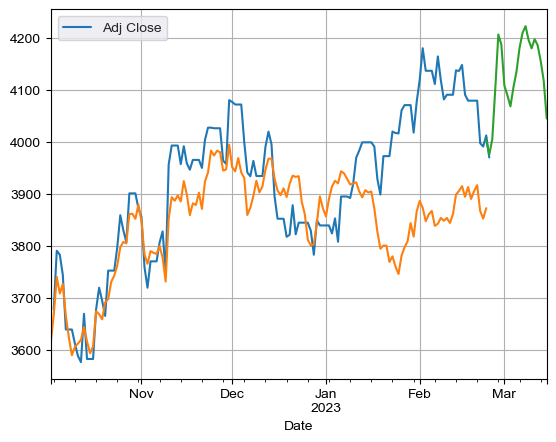

In [7]:
# Set fig and ax
fig, ax = plt.subplots()
# ax = a_df.plot(ax=ax)

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))



# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

ax = forecast.plot(ax=ax) # Green


## Regression models for portolio - ROI prediction

In [8]:
calc_projected_roi(path,tickers, 252,3)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

^GSPC : -1.52 %
CGG.PA : 3.123 %
AUDEUR=X : -1.105 %


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq

[-1.52, 3.123, -1.105]